In [3]:
import sys
sys.path.append("..")

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 90

from src.dataset import Dataset
from src.vectorizers import TokenVectorizer

In [4]:
dataset = Dataset()
dates = dataset.load_dataset(year=None, fields=["decision_date"], courts={"Illinois Appellate Court"})

In [5]:
vectors, vectorizer = TokenVectorizer.load_vectors_vectorizer(method="count")

c:\users\carle\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
print(f"Vocabulary length: {len(vectorizer.vocabulary_)}")

Vocabulary length: 48480


In [7]:
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))
id2word = dict((idx, v) for idx, v in enumerate(vocab))

vectors_trans = vectors.transpose()

c:\users\carle\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
intervals = 5
norm_dates = [e["decision_date"] - e["decision_date"]%intervals for e in dates]

dates_frequencies = defaultdict(lambda:0)

for d in norm_dates:
    dates_frequencies[d] += 1

In [9]:
def get_distribution(term, word2id, doc_dates, transposed_vectors, dates_frequencies, low_filter=-1):
    ind = word2id.get(term, -1)
    if ind < 0:
        return []
    docs = [(index, 1) for index, occ in 
            enumerate(transposed_vectors[ind].toarray()[0]) if occ > 0]
    dates = [(doc_dates[index], occ) for index, occ in docs]
    freqs = defaultdict(lambda:0)
    for year, occ in dates:
        freqs[year] += occ
            
    return sorted([(year, occ/dates_frequencies[year]) 
                   for year, occ in freqs.items() if year > low_filter])

In [10]:
get_distribution("cannabis", word2id, norm_dates, vectors_trans, dates_frequencies, low_filter=1820)

[(1935, 0.000273972602739726),
 (1955, 0.001084010840108401),
 (1965, 0.0013547076089410702),
 (1970, 0.005998500374906273),
 (1975, 0.019143117593436645),
 (1980, 0.02230437461491066),
 (1985, 0.021460713049498096),
 (1990, 0.028432956381260095),
 (1995, 0.026041666666666668),
 (2000, 0.03903508771929825),
 (2005, 0.040878896269800714),
 (2010, 0.03996101364522417)]

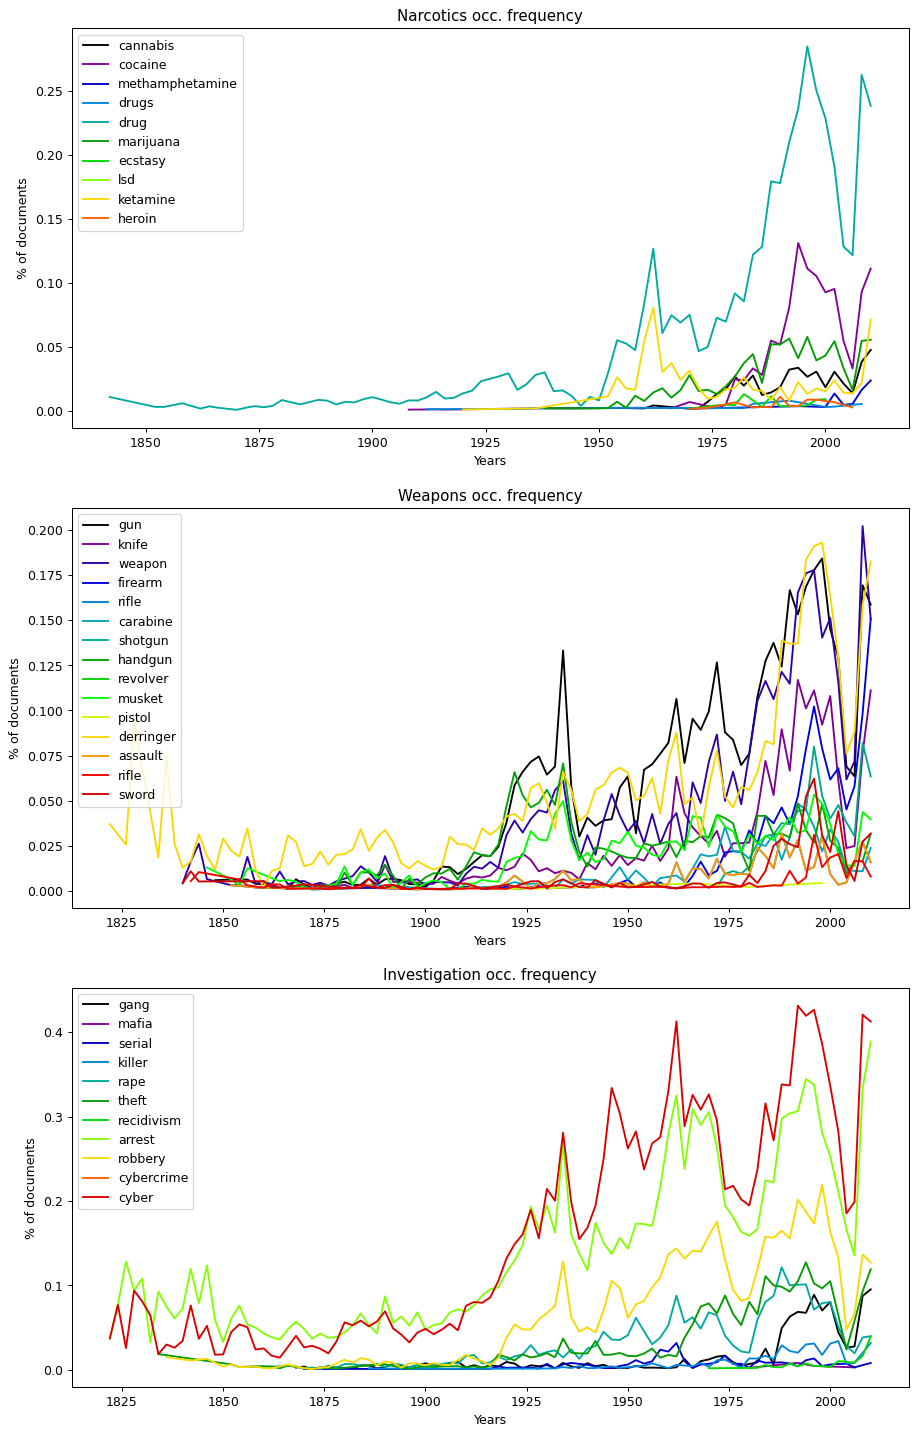

In [17]:

narcotics = ['cannabis', 'cocaine', 'methamphetamine', 'drugs', 'drug', 'marijuana', 
             'ecstasy', 'lsd', 'ketamine', 'heroin', 'fentanyl', 'overdose']

weapons = ['gun', 'knife', 'weapon', 'firearm', 'rifle', 'carabine', 'shotgun', 'handgun', 
           'revolver', 'musket', 'pistol', 'derringer', 'assault', 'rifle', 'sword', 'blunt']

investigation = ['gang', 'mafia', 'serial',  'killer', 'rape', 'theft', 'recidivism', 
                 'arrest', 'robbery', 'cybercrime', 'cyber', 'crime']

titles = ["Narcotics", "Weapons", "Investigation"]

fig, axs = plt.subplots(3,1, figsize=(12,20))

colormap = plt.cm.nipy_spectral

for i, words in enumerate([narcotics, weapons, investigation]):
    
    colors = [colormap(i) for i in np.linspace(0, 1,len(words))]
    axs[i].set_prop_cycle('color', colors)
    
    for word in words:
    
        dist = get_distribution(word, word2id, norm_dates, vectors_trans, dates_frequencies, low_filter=1820)
        if not dist:
            continue
    
        x = [e[0] for e in dist]
        y = [e[1] for e in dist]
        axs[i].set(title=f"{titles[i]} occ. frequency", xlabel="Years", ylabel="% of documents")
        axs[i].plot(x, y)
        axs[i].legend(words)
        
plt.savefig("../data/images/interesting_words_occ.jpeg", dpi=300)
plt.show()